# Average Days Cross Point Finder
## 1. Import Modules

In [76]:
%matplotlib inline
from sqlalchemy import create_engine, and_
from sqlalchemy.orm import sessionmaker
from DB_Setup import Base, FullMarketDailyTrade, SingleStockDaily
import matplotlib.pyplot as plt
import pandas as pd
import datetime

## 2. Connection with database

In [2]:
engine = create_engine('sqlite:///taiwanstock.db')
# Bind the engine to the metadata of the Base class so that the
# declaratives can be accessed through a DBSession instance
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
# A DBSession() instance establishes all conversations with the database
# and represents a "staging zone" for all the objects loaded into the
# database session object. Any change made against the objects in the
# session won't be persisted into the database until you call
# session.commit(). If you're not happy about the changes, you can
# revert all of them back to the last commit by calling
# session.rollback()
session = DBSession()

## 3. Functions
### a. Easy List Printer

In [3]:
def printList(dataList):
    for items in dataList:
        print(items)


### b. Average 

In [4]:
'''Arguments: 1. stockdf: pandas dataframe\
2. avg1: string. avg5d,avg10d,avg20d,avg60d \
3. avg1: string. avg5d,avg10d,avg20d,avg60d'''
def avgCrossCal(stockdf,avg1,avg2):
    crossList = list()
    size = len(stockdf)
    for i in range(0,size,1):
        if (i+1) > size-1:
            return crossList
        avgA0 = stockdf.loc[i][avg1]
        avgA1 = stockdf.loc[i+1][avg1]
        avgB0 = stockdf.loc[i][avg2]
        avgB1 = stockdf.loc[i+1][avg2]
        if avgA0 < avgB0:
            if avgA1 >= avgB1:
                #print(stockdf.loc[i]['tradeDate'],stockdf.loc[i+1]['tradeDate'])
                #print(avgA0,avgA1)
                #print(avgB0,avgB1)
                crossList.append(stockdf.loc[i+1]['tradeDate'])
            else:
                continue
        else:
            continue

In [54]:
def dataSlope(stockdf, date, days, param):
    indexList = stockdf[stockdf['tradeDate']==date].index.tolist()
    startIndex = indexList[0]
    stopIndex = startIndex + days
    if stopIndex > len(stockdf):
        #print('out of range')
        return 0
    startPrice = stockdf.loc[startIndex][param]
    stopPrice = stockdf.loc[stopIndex][param]
    slope = (stopPrice-startPrice)/days
    return [slope,startIndex,stopIndex]

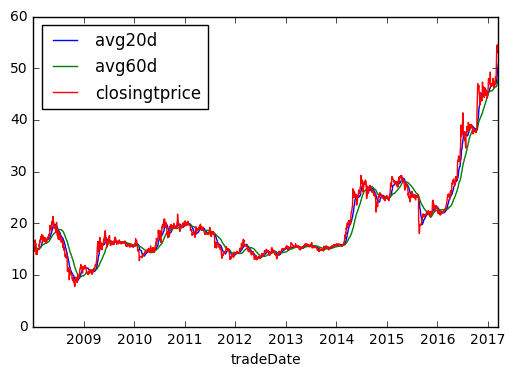

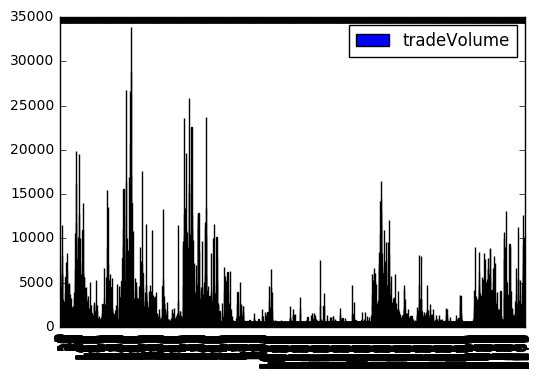

In [8]:
avg1 = 'avg20d'
avg2 = 'avg60d'

sd = SingleStockDaily
df = pd.read_sql(session.query(sd.closingtprice,sd.avg5d,sd.avg10d,sd.avg20d,sd.avg60d,sd.tradeDate,sd.tradeVolume)\
.order_by(sd.tradeDate).filter(sd.stockid=='1215').statement, session.bind)
df1 = df.copy()
df1.index = range(0,len(df1))
crossDate = avgCrossCal(df1,avg1,avg2)
df1.plot(x='tradeDate',y=[avg1,avg2,'closingtprice'])
df1.plot(y=['tradeVolume'],kind='bar')
#df1.plot(x='tradeDate',y=['closingtprice'])

In [72]:
slopeplus = list()
slopeminus = list()
for date in crossDate:
    slopeDataSet = dataSlope(df1, date, 10, 'closingtprice')
    tradeVolSet = dataSlope(df1, date, 10, 'tradeVolume')
    if slopeDataSet:
        if slopeDataSet[0] > 0:
            slopeplus.append(slopeDataSet[0])
        else:
            slopeminus.append(slopeDataSet[0])
        if tradeVolSet[0] > 0:
            print(slopeDataSet, tradeVolSet)
    #print(date,slopeData)
totalCount = len(slopeplus)+len(slopeminus)
plusPercentage = len(slopeplus)/totalCount *100
minusPercentage = len(slopeminus)/totalCount *100
print(totalCount,len(slopeplus),len(slopeminus),plusPercentage,minusPercentage)

[0.18000000000000008, 23, 33] [145.98079999999999, 23, 33]
[0.37000000000000011, 303, 313] [451.97370000000012, 303, 313]
[0.019999999999999928, 408, 418] [119.90230000000001, 408, 418]
[-0.0050000000000000712, 565, 575] [83.698400000000007, 565, 575]
[0.0, 749, 759] [10.511600000000044, 749, 759]
[0.059999999999999963, 1008, 1018] [5.9782000000000037, 1008, 1018]
[-0.044999999999999929, 1714, 1724] [25.670699999999993, 1714, 1724]
[0.15999999999999978, 2024, 2034] [12.021400000000005, 2024, 2034]
21 10 11 47.61904761904761 52.38095238095239


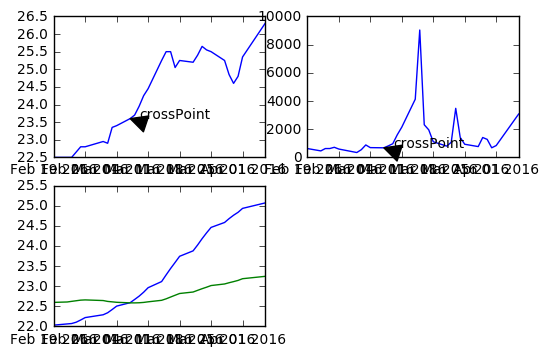

In [75]:
a = 2024
b = 2034
offset = 10
x = df.loc[a-offset:b+offset]['tradeDate']
y = df.loc[a-offset:b+offset]['closingtprice']
z = df.loc[a-offset:b+offset]['tradeVolume']
y1 = df.loc[a-offset:b+offset][avg1]
y2 = df.loc[a-offset:b+offset][avg2]
x.index = range(0,len(x))
y.index = range(0,len(y))
z.index = range(0,len(z))
y1.index = range(0,len(y1))
y2.index = range(0,len(y2))
#df[a-5:b+5].plot(x='tradeDate',y='closingtprice')
#df1[a-5:b+5].plot(y=['tradeVolume'],kind='bar')
#df[a-5:b+5].plot(x='tradeDate',y=[avg1,avg2])
ax1 = plt.subplot(2,2,1)
ax1.plot(x,y)
ax1.annotate('crossPoint', xy=(x[offset], y[offset]),xytext=(x[offset+2], y[offset]),arrowprops=dict(facecolor='black', shrink=0.01))
ax2 = plt.subplot(2,2,2)
ax2.plot(x,z)
ax2.annotate('crossPoint', xy=(x[offset], z[offset]),xytext=(x[offset+2], z[offset]),arrowprops=dict(facecolor='black', shrink=0.01))
ax3 = plt.subplot(2,2,3)
ax3.plot(x,y1,x,y2)